In [77]:
import os
import time

import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rpy2
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
numpy2ri.activate()
pandas2ri.activate()

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, confusion_matrix, auc
from sklearn.metrics import roc_curve, f1_score

import pims
from tqdm.auto import tqdm

from lib import detection
from lib import analysis
from lib import display

# Classifier V3.0: A New Hope??

We have a whole new set of cells. Let's sample puffs from each of those cells to build a training dataset. Ideally, I will have sampled randomly and have an equal number of cells from each condition. In reality, here's what condition_checker tells me:

```
condition_checker.py ~/UM\ Drive/OPP/OPP_scramble.log 0IYVHRNA.tif 19CC75ZU.tif 2TZWB6CN.tif 3W70AV4V.tif 3WE2GUYC.tif 42GSRFR0.tif 53BFW81Q.tif 56CCWWJI.tif 5FWR8G3N.tif 5RTVNBXU.tif 6SG3YVW7.tif 79NWKD4H.tif 7C4SV01F.tif 7XFW332I.tif 7XGJBQQ3.tif 7YFIHF8P.tif 8C92MS0M.tif 9VEA7WGA.tif
3 B2 cells, 8 MOR cells, 7 TfR Cells
```

So that's not...GREAT. But it's a start for a classifier. So, how do we do this?

## Sample Selection

Let's evaluate each of the cells that have been scored so far and find out the frequency of puffs and total number of puffs in those cells:

In [2]:
basedir = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP'
files = os.listdir(basedir)
tifs = [tif for tif in files if 'tif' in tif]
xmls = [xml for xml in files if 'xml' in xml]
movie_info = {}
for tif in tifs:
    movie_name = tif.split('.')[0]
    matches = [xml for xml in xmls if movie_name in xml]
    if matches:
        movie_info[movie_name] = {'tif' : tif,
                                  'xml' : matches[0]}

In [9]:
for movie in movie_info:
    events = pd.read_csv('data/'+movie+'.tif_events.csv', index_col=False)
    marker_locs = detection.import_xml_data(basedir + os.sep + movie_info[movie]['xml'])
    puff_ids = np.array([detection.filter_df(events, m, 5) for m in marker_locs])
    print('%d puffs in %d events (%.4f puff rate)' % (len(np.unique(puff_ids[puff_ids>0])),
                                                      len(np.unique(events['particle'])),
                                                      (len(np.unique(puff_ids[puff_ids>0]))/len(np.unique(events['particle'])))))

35 puffs in 6090 events (0.0057 puff rate)
370 puffs in 8716 events (0.0425 puff rate)
55 puffs in 5149 events (0.0107 puff rate)
65 puffs in 9588 events (0.0068 puff rate)
488 puffs in 9346 events (0.0522 puff rate)
62 puffs in 8909 events (0.0070 puff rate)
509 puffs in 10202 events (0.0499 puff rate)
71 puffs in 6002 events (0.0118 puff rate)
108 puffs in 10202 events (0.0106 puff rate)
37 puffs in 9594 events (0.0039 puff rate)
482 puffs in 7765 events (0.0621 puff rate)
34 puffs in 3511 events (0.0097 puff rate)
254 puffs in 10725 events (0.0237 puff rate)
266 puffs in 6732 events (0.0395 puff rate)
72 puffs in 7732 events (0.0093 puff rate)
16 puffs in 4843 events (0.0033 puff rate)
604 puffs in 8056 events (0.0750 puff rate)
183 puffs in 3715 events (0.0493 puff rate)


That's a large range, but overall a small enough number of a events to be able to try training a clasffiier on all cells! Let's load in the features calculated for all these events:

In [11]:
features_list = []
for movie in tqdm(list(movie_info.keys())):
    intensities = pd.read_csv('data/' + movie + ".tif_intensities.csv", index_col=0)
    puff_ids_to_sample = intensities.loc[intensities['puff']==1,'particle'].values
    features = pd.read_csv('data/' + movie + ".tif_features.csv", index_col=0)
    features.loc[:, 'cell'] = movie
    features.loc[:, 'puff'] = features['particle'].isin(puff_ids_to_sample).astype(int)
    features_list.append(features)
    
labeled_sample = pd.concat(features_list, ignore_index=True)

In [50]:
print('%d puffs in %d events (%.4f puff rate)' % (np.sum(labeled_sample['puff']),
                                                  np.shape(labeled_sample)[0],
                                                  (np.sum(labeled_sample['puff'])/np.shape(labeled_sample)[0])))

3711 puffs in 136878 events (0.0271 puff rate)


In [13]:
labeled_sample.columns

Index(['cell', 'particle', 'conv_perim', 'conv_area', 'lifetime_s',
       'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
       'cc22', 'cc23', 'deltaf', 'tau', 'residuals_max', 'residuals_min',
       'residuals_mean', 'residuals_median', 'residuals_std', 'snr_max',
       'snr_min', 'snr_mean', 'snr_median', 'snr_std', 'puff'],
      dtype='object')

This enrichment is at about the rate that we had seen previously with the 10Hz movies, which we were able to (in some cases) detect events. Cool! Let's try it!

## Classifier

With a puff sample detected, we can now generate a classifier trained on it. For this, we're using all of the cross-correlation features that Ciaran generated, as well as area and perimeter of the convex hull, plus event lifetime, total change in fluorescence over event lifetime, and time to reach half-max after maximum.

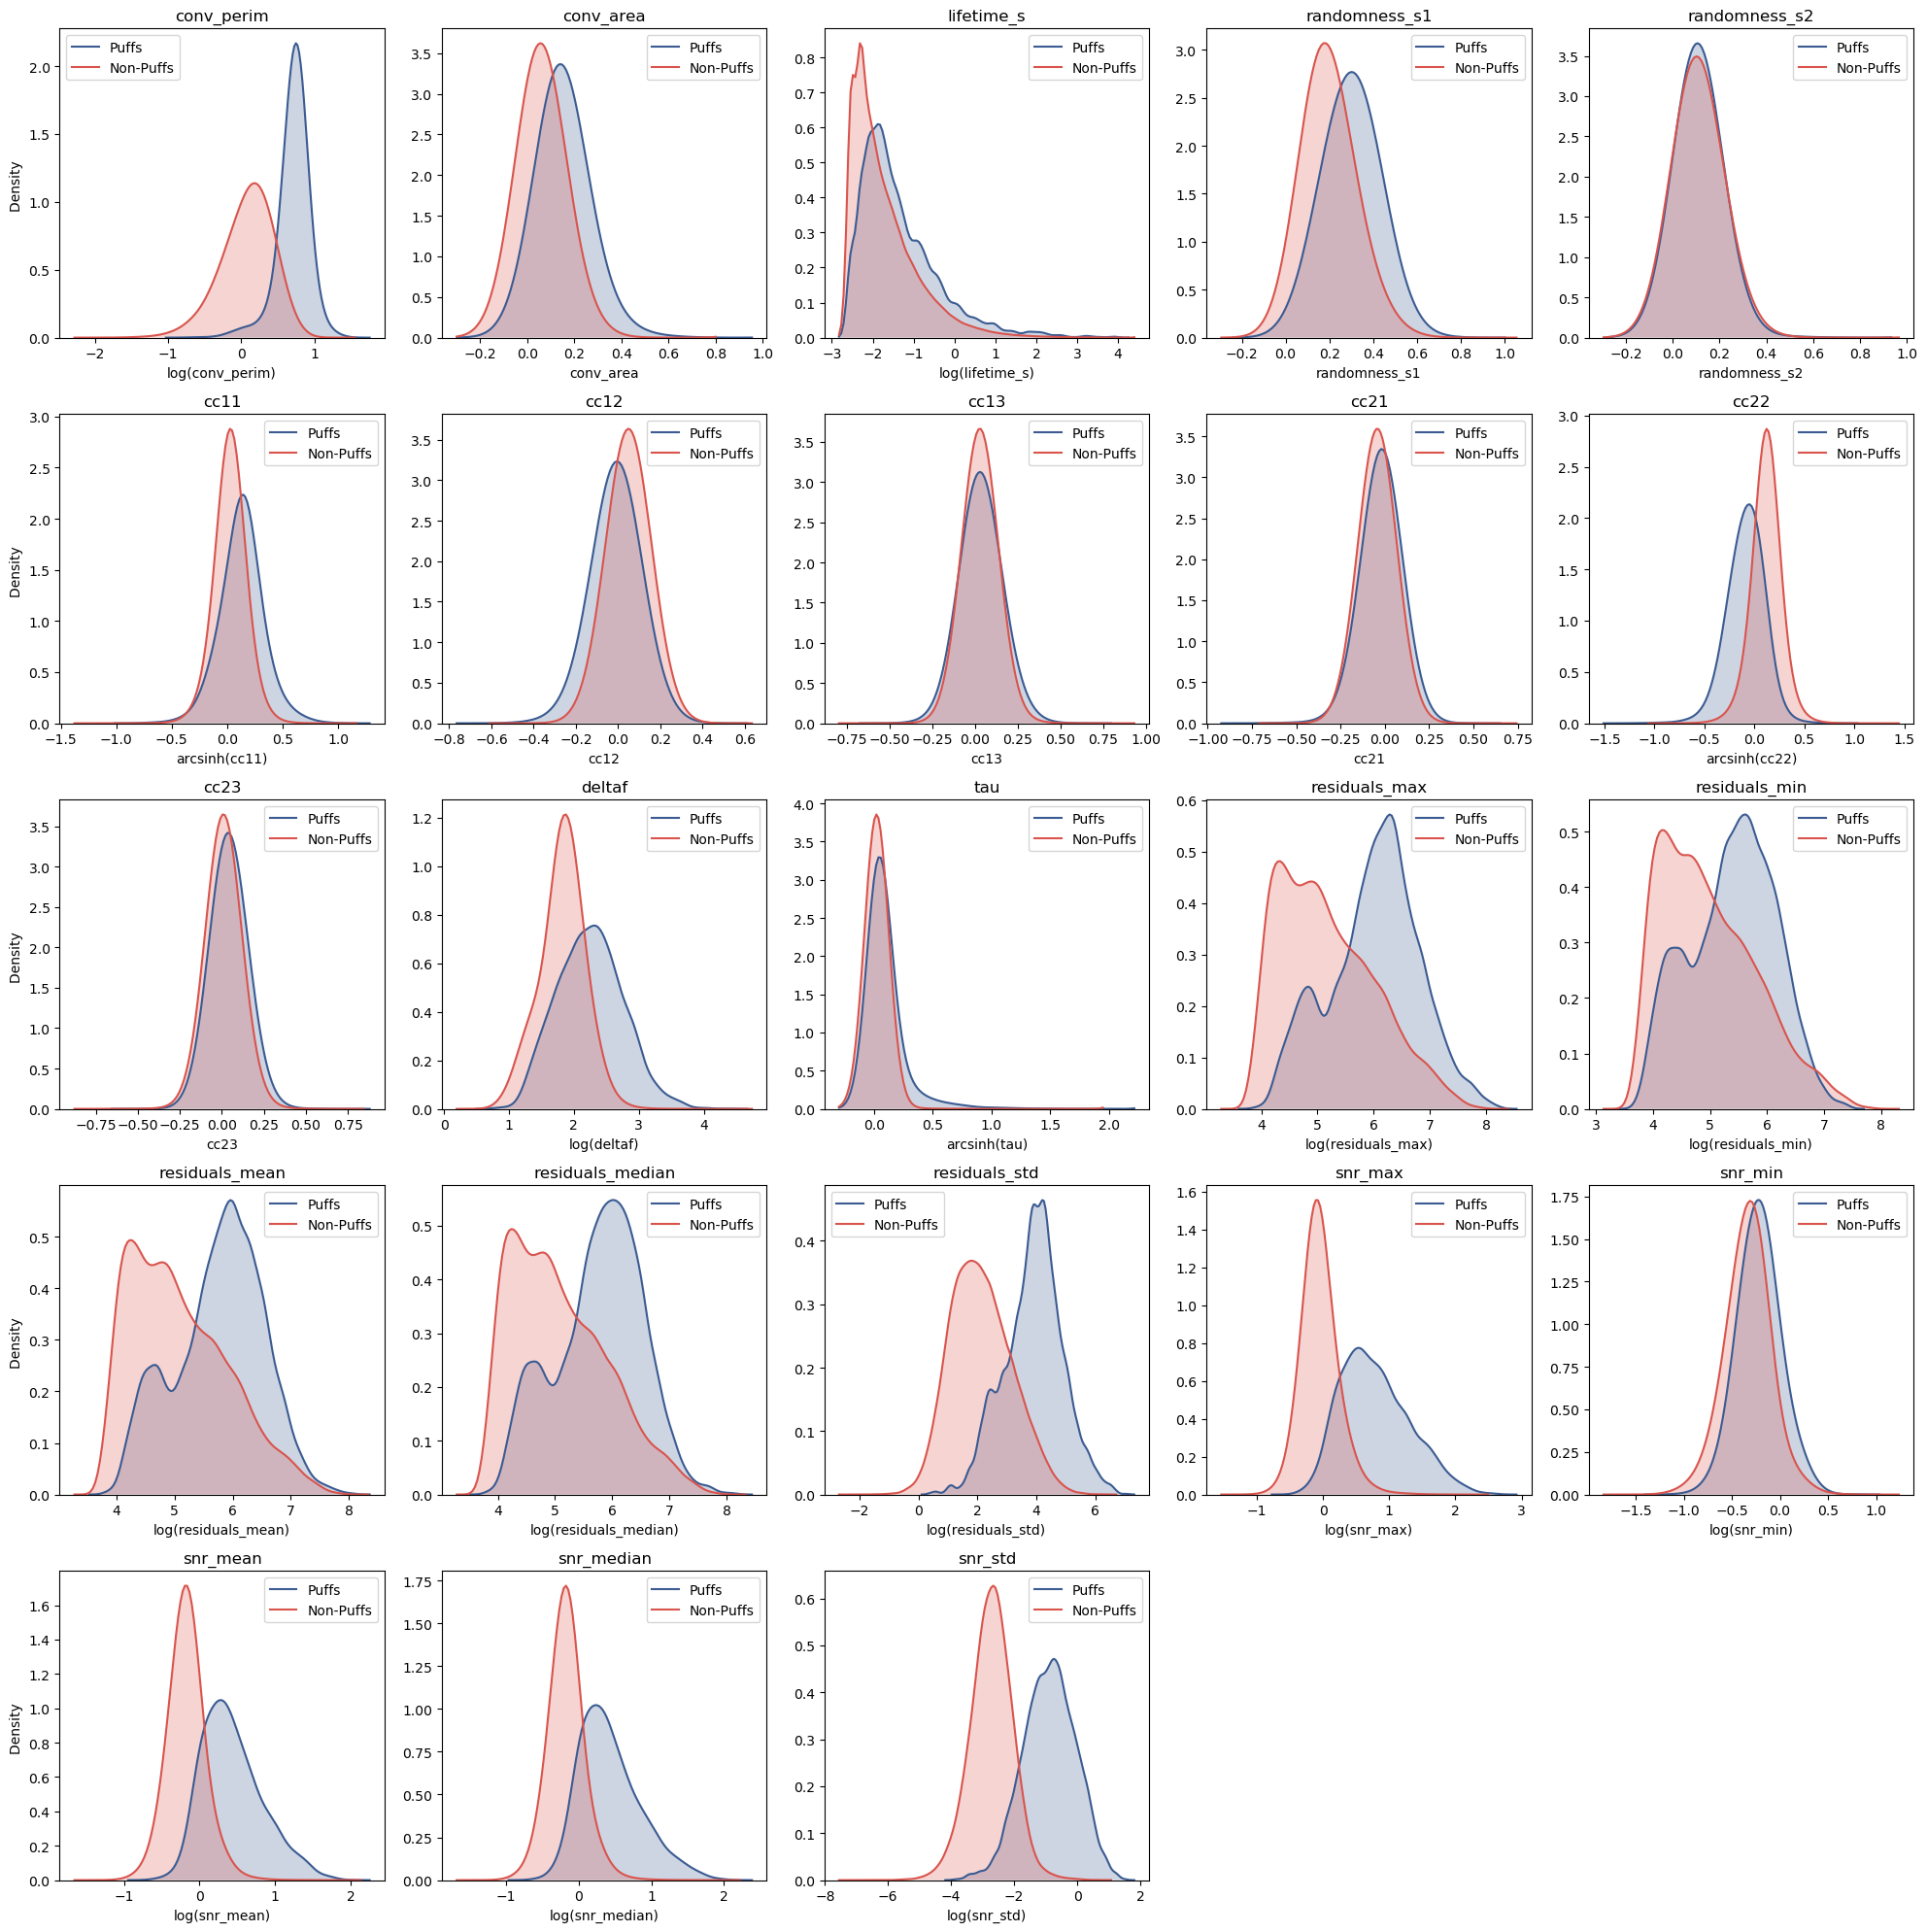

In [14]:
sns.set_palette(sns.color_palette([sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red']]))

nrows = 5
features = ['conv_perim', 'conv_area', 'lifetime_s',
       'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
       'cc22', 'cc23', 'deltaf', 'tau', 'residuals_max', 'residuals_min',
       'residuals_mean', 'residuals_median', 'residuals_std', 'snr_max',
       'snr_min', 'snr_mean', 'snr_median', 'snr_std']

fig, axes = plt.subplots(math.ceil(np.shape(features)[0]/nrows),
                         nrows)
fig.set_size_inches(20,20)

for counter, feature in enumerate(features):
    if counter % nrows == 0:
        axes.ravel()[counter].set_ylabel('Density ')
    axes.ravel()[counter].set_title(feature)
    dist = labeled_sample[feature]
    puff_dist = dist[labeled_sample['puff'] == 1]
    nonpuff_dist = dist[labeled_sample['puff'] == 0]
    dist = dist[~np.isnan(dist)]
    puff_dist = puff_dist[~np.isnan(puff_dist)]
    nonpuff_dist = nonpuff_dist[~np.isnan(nonpuff_dist)]
    
    if (np.max(dist) > 1):
        if np.any(dist <= 0):
            sns.kdeplot(np.arcsinh(puff_dist), label = 'Puffs', bw = 0.1, shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('arcsinh(' + feature + ')')
            sns.kdeplot(np.arcsinh(nonpuff_dist), label = 'Non-Puffs', bw = 0.1, shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('arcsinh(' + feature + ')')
        else:
            sns.kdeplot(np.log(puff_dist), label = 'Puffs', bw = 0.1, shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('log(' + feature + ')')
            sns.kdeplot(np.log(nonpuff_dist), label = 'Non-Puffs', bw = 0.1, shade = True,
                        ax = axes.ravel()[counter]).set_xlabel('log(' + feature + ')')
    else:
        sns.kdeplot(puff_dist, label = 'Puffs', bw = 0.1, shade = True,
                     ax = axes.ravel()[counter]).set_xlabel(feature)
        sns.kdeplot(nonpuff_dist, label = 'Non-Puffs', bw = 0.1, shade = True,
                     ax = axes.ravel()[counter]).set_xlabel(feature)

for idx in np.arange(counter+1,len(axes.ravel())):
    axes.ravel()[idx].axis('off')
plt.tight_layout()
sns.reset_defaults()

The following is the evaluated OOB sample on a calssifier trained on all of the data. 

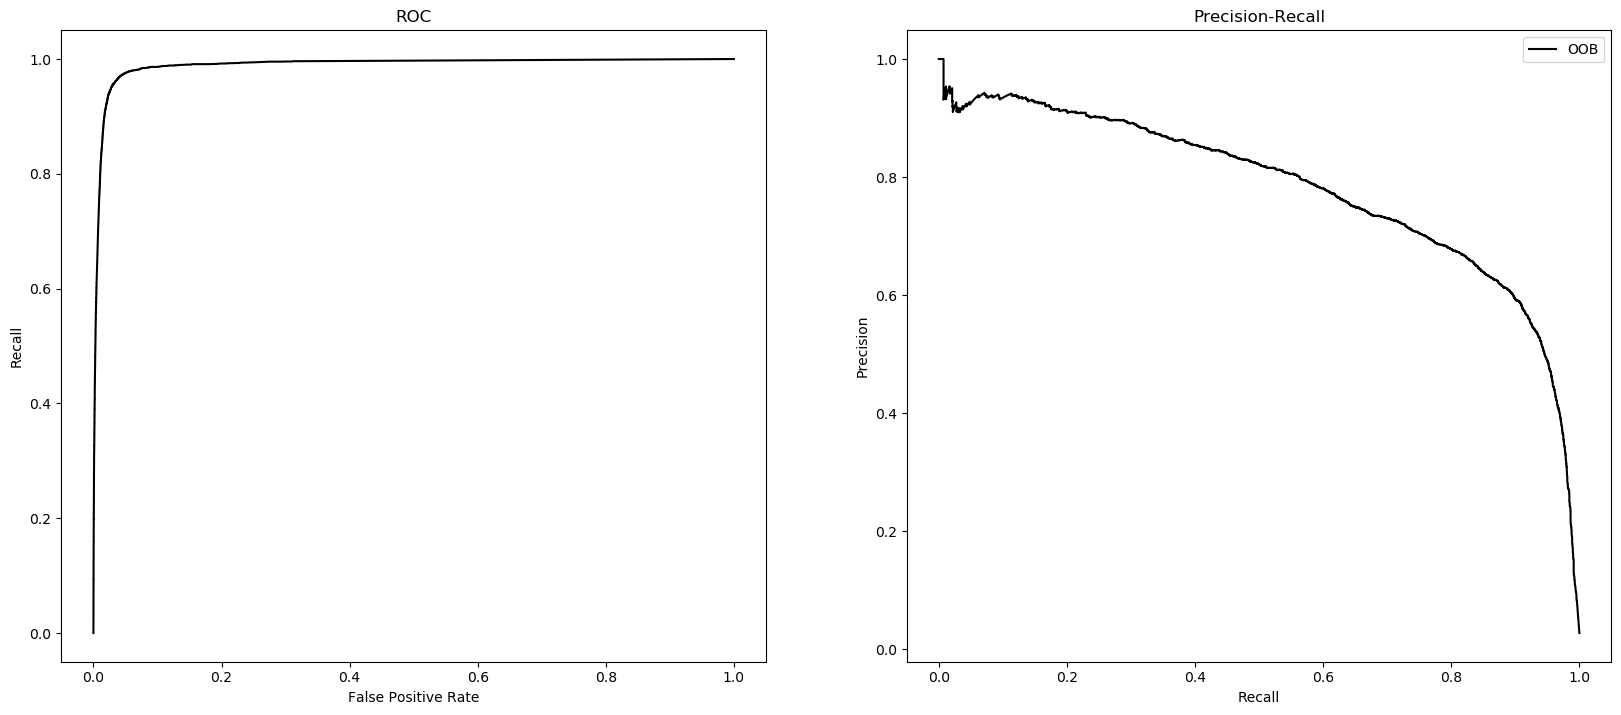

In [20]:
global_classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)

training_fields = ['conv_perim', 'conv_area', 'lifetime_s',
       'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
       'cc22', 'cc23', 'deltaf', 'tau', 'residuals_max', 'residuals_min',
       'residuals_mean', 'residuals_median', 'residuals_std', 'snr_max',
       'snr_min', 'snr_mean', 'snr_median', 'snr_std']

global_classifier.fit(labeled_sample[training_fields], labeled_sample['puff'])

plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
fpr, tpr , thresholds= roc_curve(labeled_sample['puff'], global_classifier.oob_decision_function_[:,1], pos_label = 1)
ax1.plot(fpr, tpr, label="OOB", color="k")
precision, recall, thresholds = precision_recall_curve(labeled_sample['puff'], global_classifier.oob_decision_function_[:,1],pos_label = 1)
ax2.plot(recall, precision, label="OOB", color="k")
plt.legend()

Distribution of predicted puffness for puffs and non-puffs:

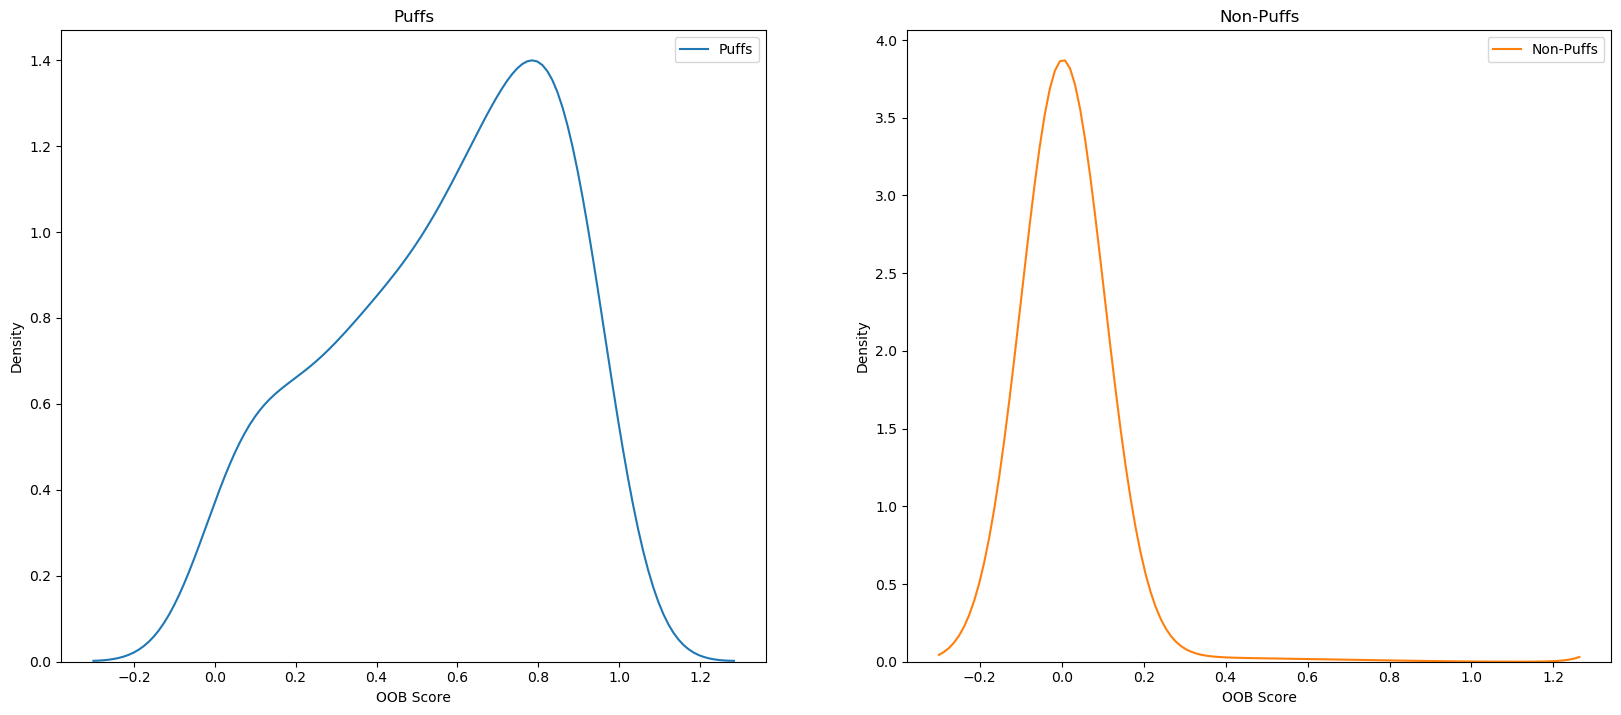

In [21]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('OOB Score')
ax1.set_ylabel('Density')
ax1.set_title('Puffs')
ax2 = plt.subplot(122)
ax2.set_xlabel('OOB Score')
ax2.set_ylabel('Density')
ax2.set_title('Non-Puffs')
sns.kdeplot(global_classifier.oob_decision_function_[labeled_sample['puff'] == 1, 1], label="Puffs", ax=ax1, bw=0.1)
sns.kdeplot(global_classifier.oob_decision_function_[labeled_sample['puff'] == 0, 1], label="Non-Puffs", ax=ax2, color="C1", bw=0.1)

In [72]:
# How many puffs/nonpuffs do we have with a high OOB probability?
cutoff = 0.01
nonpuff_idx = labeled_sample["puff"] == 0
nonpuff_oob = global_classifier.oob_decision_function_[nonpuff_idx,1]
puff_idx = labeled_sample["puff"] == 1
puff_oob = global_classifier.oob_decision_function_[puff_idx,1]
print("For a cutoff of %.2f, there are %d puffs and %d nonpuffs." % (cutoff, np.sum(puff_oob>cutoff), np.sum(nonpuff_oob>cutoff)))

For a cutoff of 0.01, there are 3653 puffs and 10362 nonpuffs.


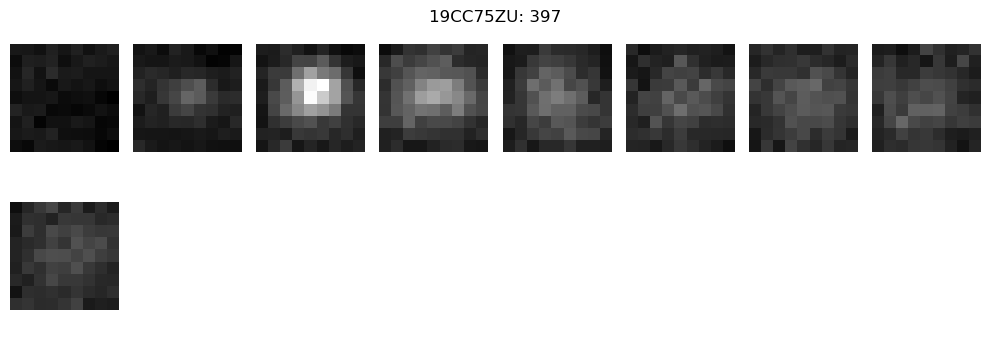

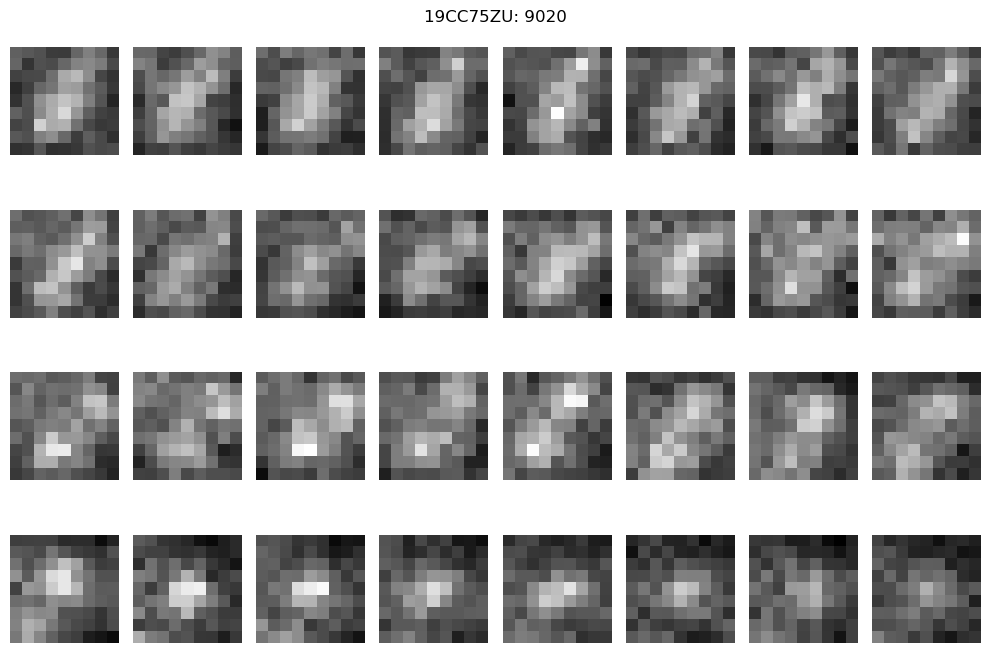

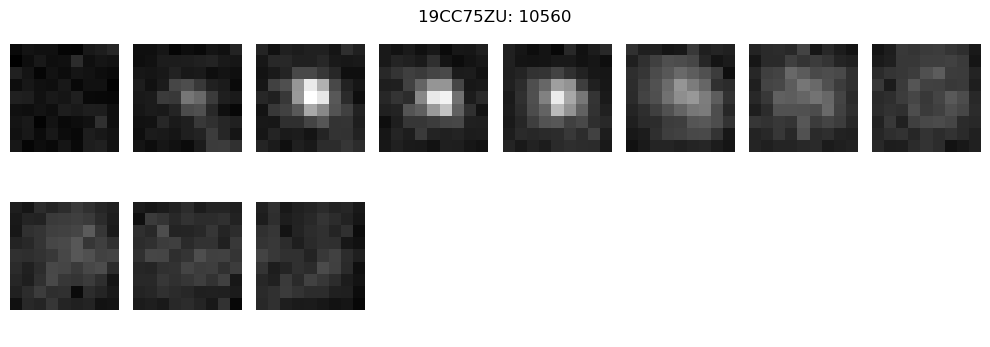

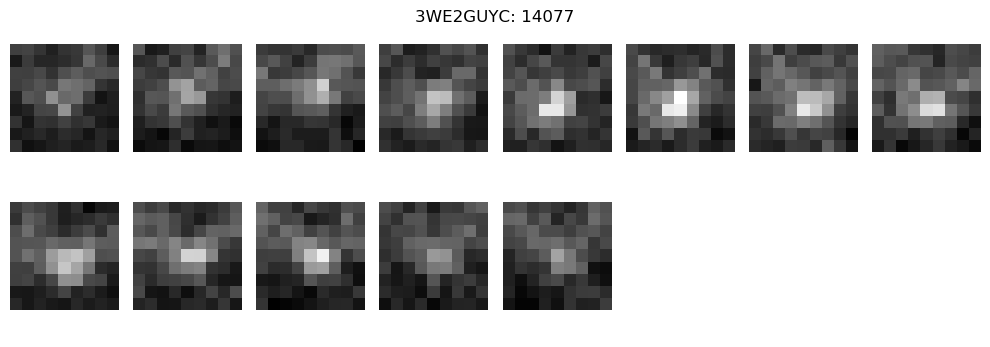

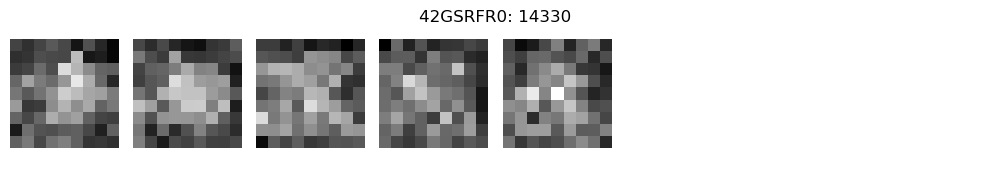

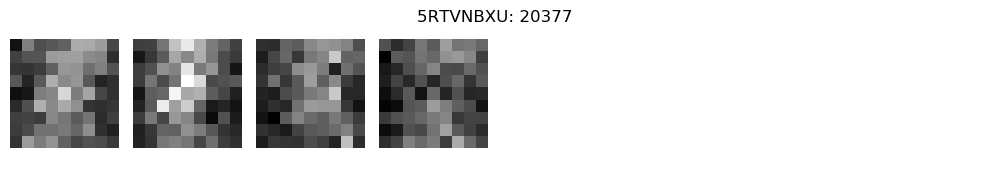

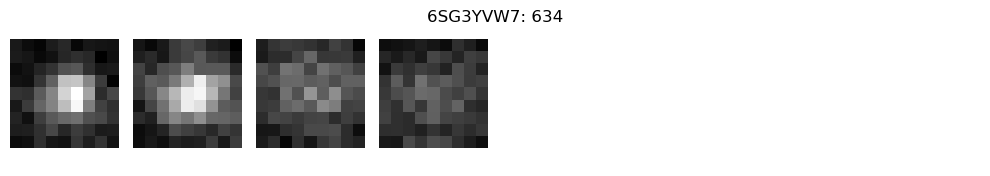

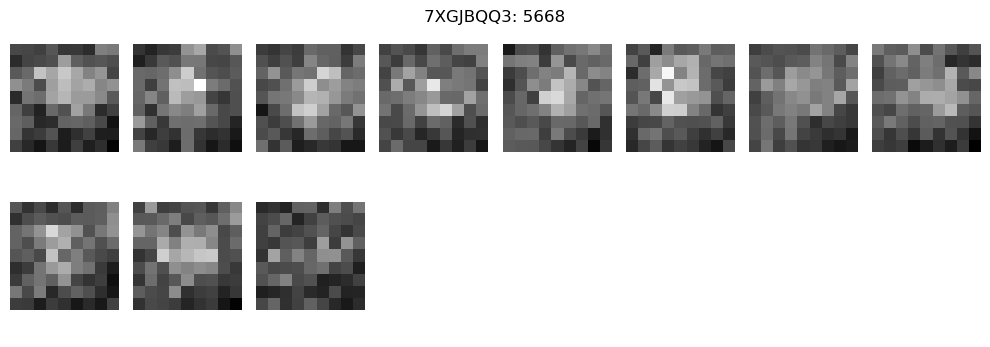

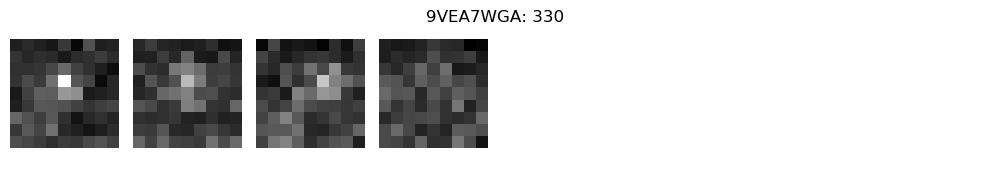

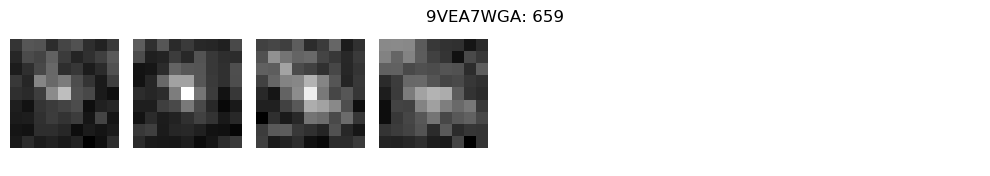

In [73]:
#Let's look at some random nonpuffs with high scores
high_np_idx = (labeled_sample["puff"] == 0) & (global_classifier.oob_decision_function_[:,1] > cutoff)
nonpuff_sample = labeled_sample.loc[high_np_idx,:]
nonpuff_sample = nonpuff_sample.iloc[np.random.choice(len(nonpuff_sample), size=10, replace=False),:]
for cell in np.unique(nonpuff_sample["cell"]):
    intensities = intensities = pd.read_csv('data/' + cell + ".tif_intensities.csv", index_col=0)
    subsample = nonpuff_sample.loc[nonpuff_sample["cell"] == cell, :]
    for particle in np.unique(subsample['particle']):
        frames = display.get_frames(intensities.loc[intensities['particle'] == particle,:])
        fig, axs = display.plot_montage(frames)
        fig.suptitle(cell + ": " + str(particle))

That's not the worst! Do we improve if we restrict the lifetime of events? In this case, we're only including events that are greater than 10 frames in length.

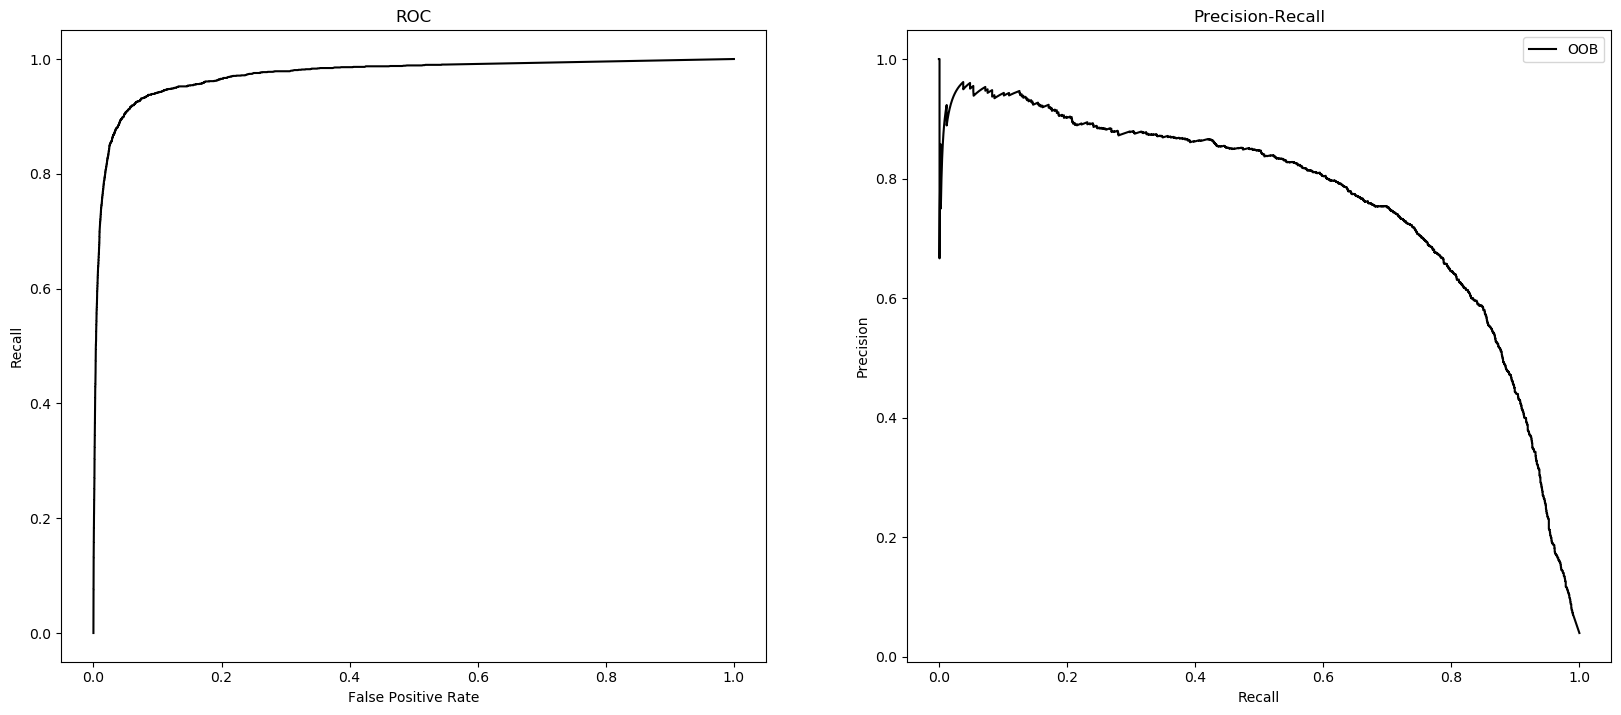

In [22]:
subsample = labeled_sample.loc[labeled_sample['lifetime_s'] >= 0.2, :]
long_classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)

training_fields = ['conv_perim', 'conv_area',
                   'cc11', 'cc12', 'cc13',
                   'cc21', 'cc22', 'cc23',
                   'lifetime_s', 'deltaf', 'tau']

long_classifier.fit(subsample[training_fields], subsample['puff'])

plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
fpr, tpr , thresholds= roc_curve(subsample['puff'], long_classifier.oob_decision_function_[:,1], pos_label = 1)
ax1.plot(fpr, tpr, label="OOB", color="k")
precision, recall, thresholds = precision_recall_curve(subsample['puff'], long_classifier.oob_decision_function_[:,1],pos_label = 1)
ax2.plot(recall, precision, label="OOB", color="k")
plt.legend()

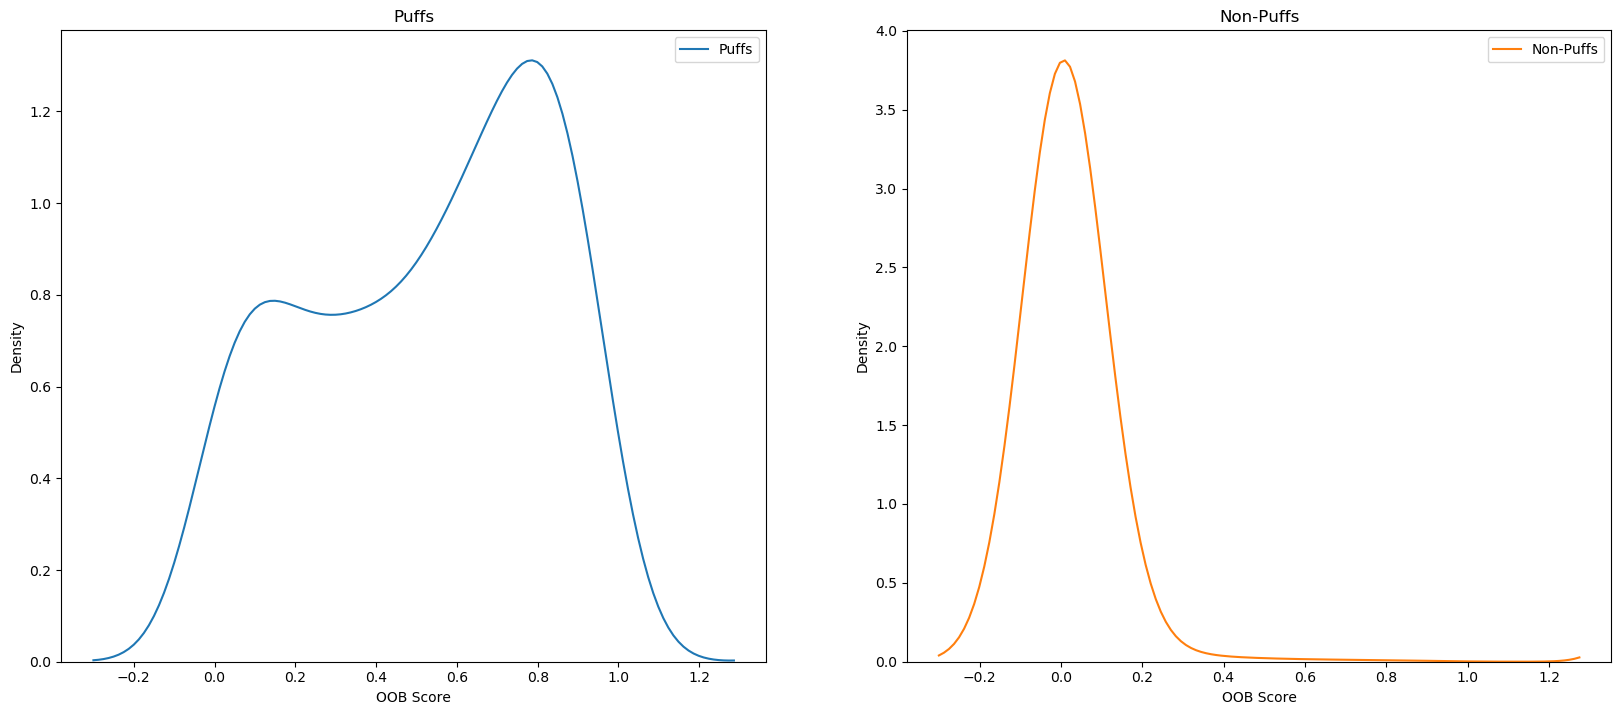

In [23]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('OOB Score')
ax1.set_ylabel('Density')
ax1.set_title('Puffs')
ax2 = plt.subplot(122)
ax2.set_xlabel('OOB Score')
ax2.set_ylabel('Density')
ax2.set_title('Non-Puffs')
sns.kdeplot(long_classifier.oob_decision_function_[subsample['puff'] == 1, 1], label="Puffs", ax=ax1, bw=0.1)
sns.kdeplot(long_classifier.oob_decision_function_[subsample['puff'] == 0, 1], label="Non-Puffs", ax=ax2, color="C1", bw=0.1)

Slight improvement, but not dramatic. What about the round-robin style classifier, trained on all data except one held-out cell?

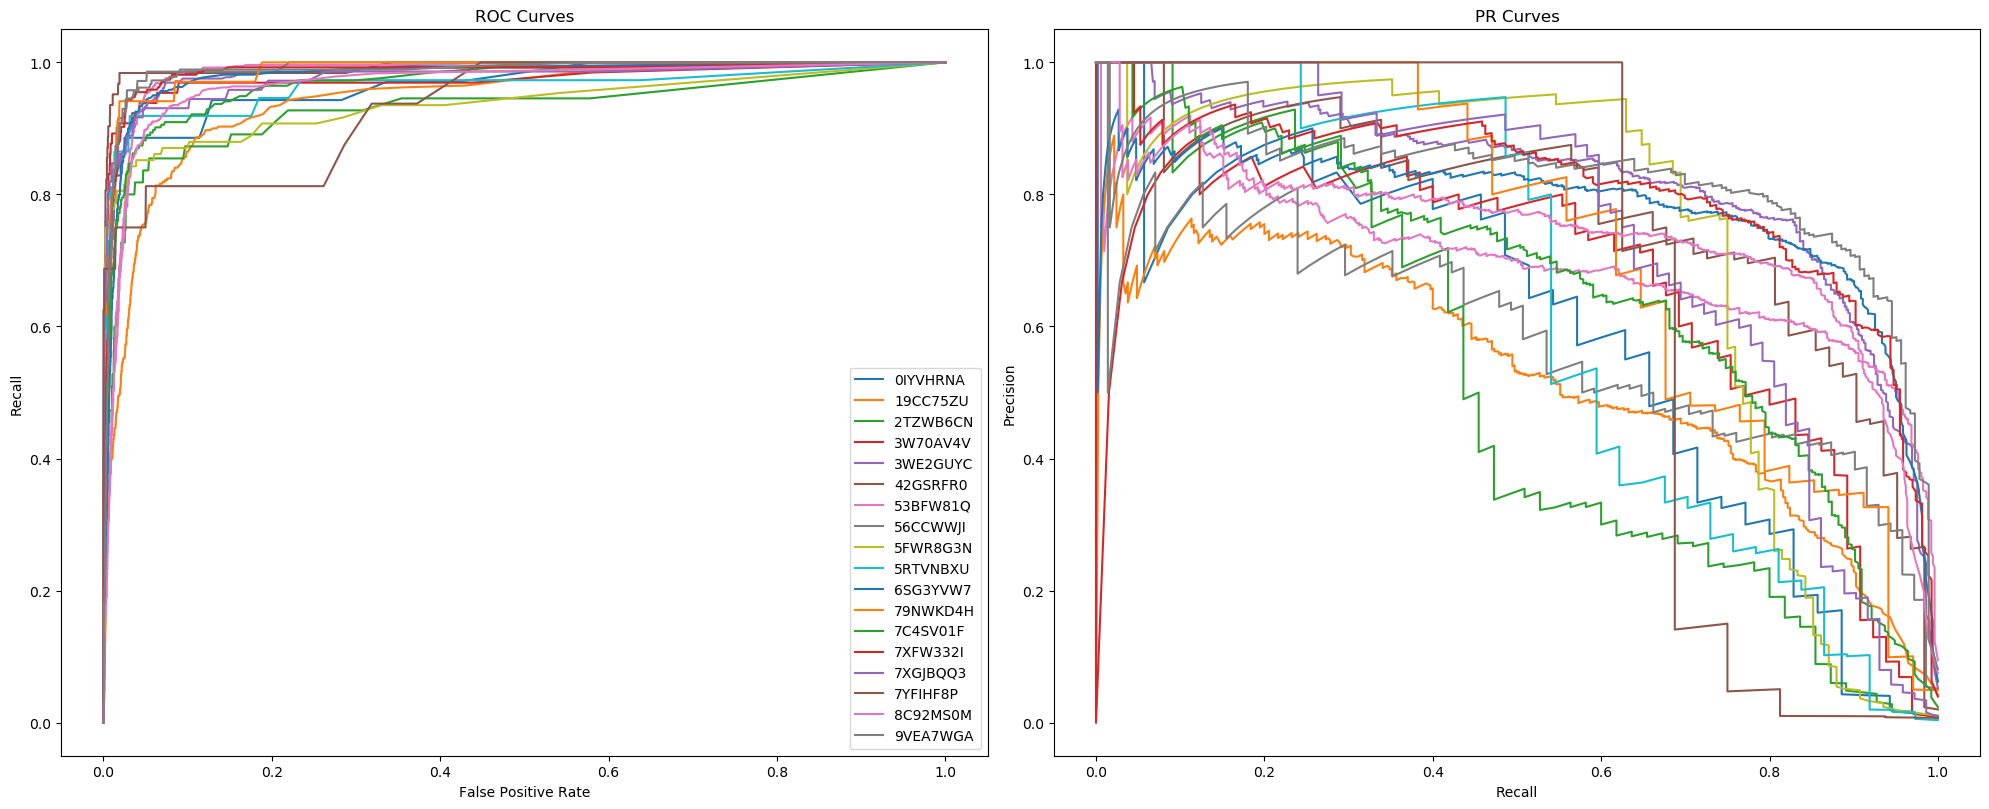

In [19]:
plt.figure(figsize=(20,8.2))
ax1 = plt.subplot(121)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('Recall')
ax1.set_title('ROC Curves')
ax2 = plt.subplot(122)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curves')

rr_classifiers = {}

for cell in tqdm(np.unique(labeled_sample['cell'])):
    held_data = labeled_sample.loc[labeled_sample['cell'] == cell]
    train_data = labeled_sample.loc[labeled_sample['cell'] != cell]
    classifier = RandomForestClassifier(
        n_estimators = 2000, 
        oob_score = True, 
        class_weight="balanced", 
        random_state=237,
        n_jobs=4)
    classifier.fit(train_data[training_fields], train_data['puff'])
    probas_ = classifier.predict_proba(held_data[training_fields])
    fpr, tpr , thresholds= roc_curve(held_data['puff'], probas_[:,1], pos_label = 1)
    ax1.plot(fpr, tpr, label=cell)
    precision, recall, thresholds = precision_recall_curve(held_data['puff'], probas_[:,1],pos_label = 1)
    ax2.plot(recall, precision, label=cell)
    labeled_sample.loc[labeled_sample['cell'] == cell, 'proba'] = probas_[:,1]
    rr_classifiers[cell] = classifier
                             
ax1.legend()
plt.tight_layout()
plt.show()

That performance is pretty variable, but decent on some cells! What about with regards to puff populations?

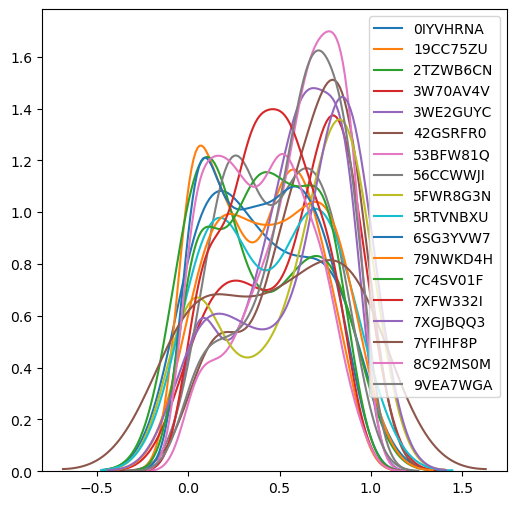

In [312]:
g = plt.figure(figsize=(6,6))
for cell in np.unique(labeled_sample['cell']):
    sns.kdeplot(labeled_sample.loc[(labeled_sample['cell'] == cell) &
                                   (labeled_sample['puff'] == 1), 'proba'].values, label=cell)

There are definitely some cells where we do not do a good job of estimating puffs. Can we possibly predict that based on puff frequency in those cells? What about the number of puffs in a given cell?

In [313]:
scores_for_thresh = []

for cell in np.unique(labeled_sample['cell']):
    puffs = labeled_sample.loc[labeled_sample['cell'] == cell, 'puff'].values
    probas = labeled_sample.loc[labeled_sample['cell'] == cell, 'proba'].values
    for thresh in [0.2, 0.4, 0.6, 0.8]:
        f1 = f1_score(puffs, probas>thresh)
        puff_freq = np.sum(puffs) / len(puffs)
        num_puffs = np.sum(puffs)
        scores_for_thresh.append({'cell' : cell,
                                  'puff_freq' : puff_freq,
                                  'num_puffs' : num_puffs,
                                  'threshold' : thresh,
                                  'f1_score': f1})
scores_for_thresh = pd.DataFrame(scores_for_thresh)

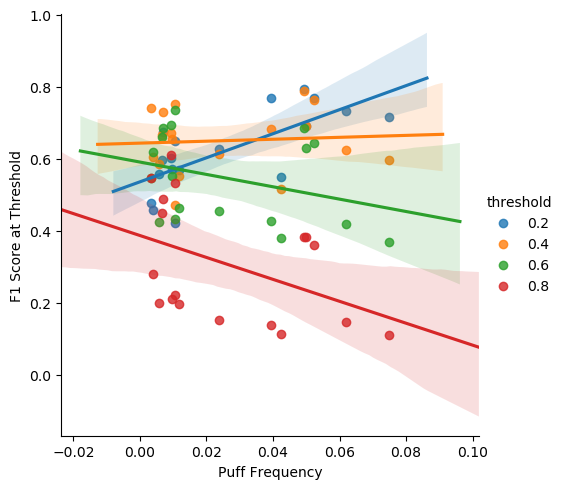

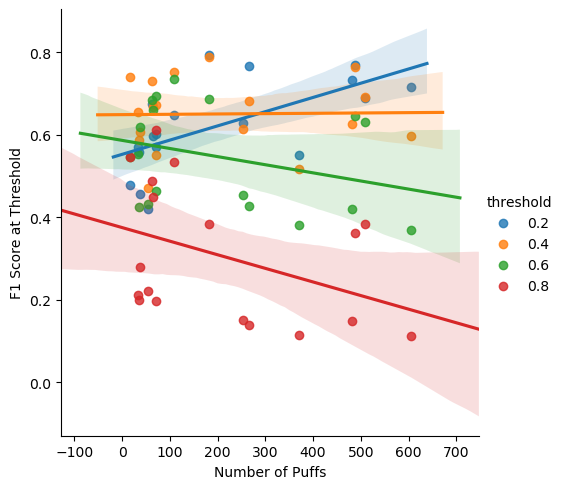

In [318]:
g = sns.lmplot(data=scores_for_thresh, x='puff_freq', y='f1_score', hue='threshold')
g.set(xlabel='Puff Frequency', ylabel='F1 Score at Threshold')
g1 = sns.lmplot(data=scores_for_thresh, x='num_puffs', y='f1_score', hue='threshold')
g1.set(xlabel='Number of Puffs', ylabel='F1 Score at Threshold')

There's some relationship between puff frequency and performance, albeit weak. Let's see if black box label shift estimation works to rectify some of that. Again, here we'll use the round robin classifier to test on held out cells, then use the probability distributions to compute the estimated base rate of cells.

As noted above, there's a lot of variability of the puff rate across the cells in the dataset:

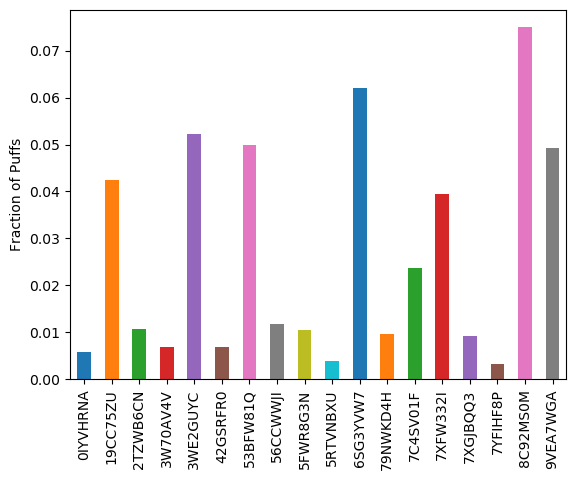

In [118]:
cell_res = pd.DataFrame({'cell': np.unique(labeled_sample['cell'])})

for cell in cell_res['cell']:
    cell_puffs = labeled_sample.loc[labeled_sample['cell'] == cell, 'puff']
    cell_res.loc[cell_res['cell'] == cell , 'n'] = len(cell_puffs)
    cell_res.loc[cell_res['cell'] == cell , 'true_count'] = np.sum(cell_puffs)
    cell_res.loc[cell_res['cell'] == cell , 'true_frac'] = np.mean(cell_puffs)

ax = cell_res.plot.bar(x = 'cell', y = 'true_frac', color=sns.color_palette(), legend = False)
ax.set_xlabel('')
ax.set_ylabel('Fraction of Puffs')
plt.show()

We can test against several methods for estimating the baserate:

- Estimate rate as the average puff probability (the mean of the returned probabilities)
- Estimate rate as fraction of the events with a probability of a given cutoff
- Estimate rate using the black box label shift estimation from Lipton et al. 2018

Here we test each of these, and display the results as ratio of estimate to actual puff rate for each cell:

In [301]:
# BBSE from Lipton et al 2018
def base_rate_correction(train_y, train_f, test_f, thresh=0.5):
    _, train_props = np.unique(train_y, return_counts=True)
    train_props = train_props*1.0/len(train_y)
    train_conf = pd.crosstab(index=train_f>thresh, columns=train_y)
    train_conf = train_conf*1.0/train_conf.values.sum()
    _, test_pred_props = np.unique(test_f>thresh, return_counts=True)
    test_pred_props = test_pred_props*1.0/len(test_f)
    w = np.matmul(np.linalg.solve(train_conf, np.identity(2)), test_pred_props)
    muy = train_props*w
    return muy[1]

In [302]:
for held_cell, classifier in rr_classifiers.items():
    test_puff_probs = labeled_sample.loc[labeled_sample['cell']==held_cell, 'proba'].values
    train_puff_probs = classifier.oob_decision_function_[:,1]
    train_puff_labels = labeled_sample.loc[labeled_sample['cell']!=held_cell, 'puff'].values

    #Correct probabilities using cell matching
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_mean'] = np.mean(test_puff_probs)
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_thresh'] = np.mean(test_puff_probs > 0.5)
    cell_res.loc[cell_res['cell'] == held_cell, 'est_frac_corr'] = base_rate_correction(train_puff_labels,
                                                                                        train_puff_probs,
                                                                                        test_puff_probs, thresh=0.5)

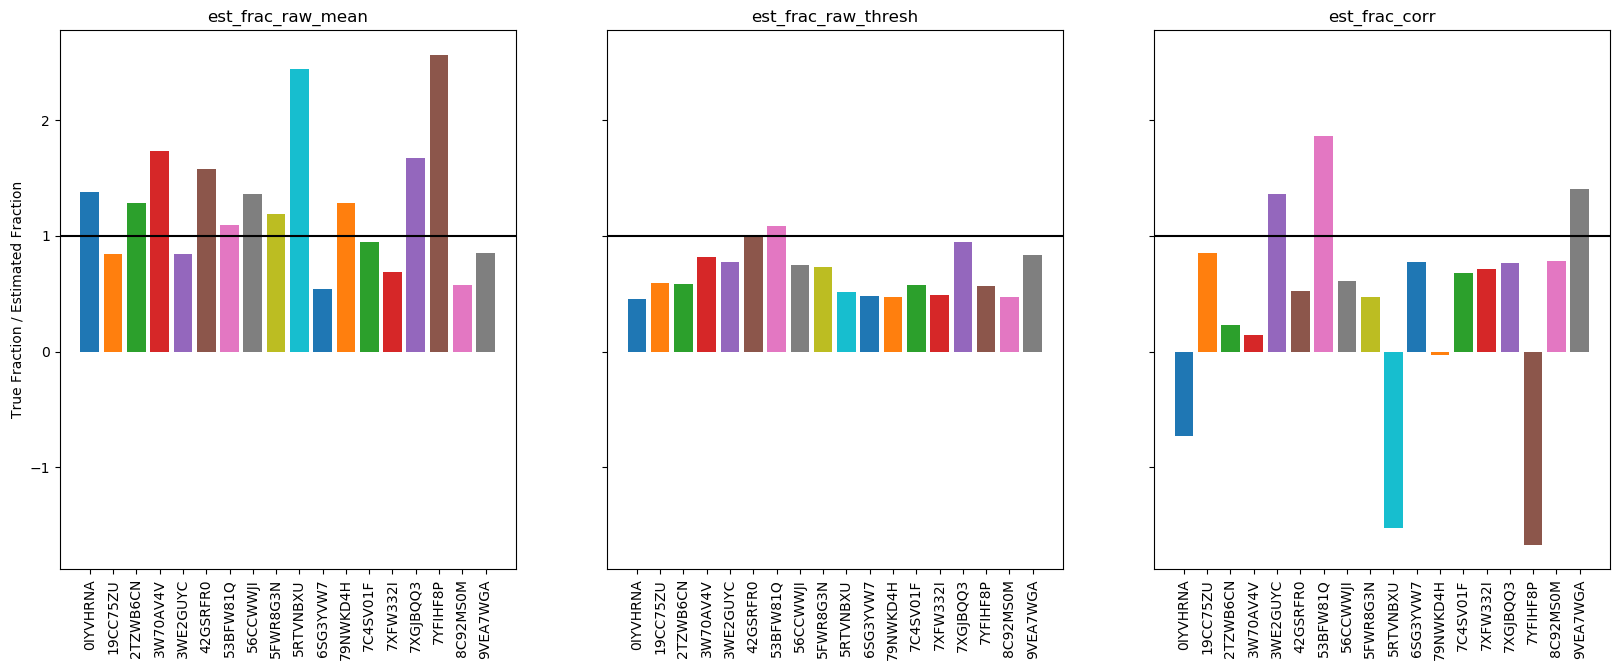

In [303]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize=(20,7))
axs[0].set_ylabel('True Fraction / Estimated Fraction')

pred_diff = {}
for ax, est in enumerate(['est_frac_raw_mean', 'est_frac_raw_thresh', 'est_frac_corr']):
    pred_diff[est] = cell_res[est] / cell_res['true_frac']
    for counter, cell in enumerate(cell_res['cell']):
        axs[ax].bar(cell, pred_diff[est][counter])
    axs[ax].set_xticklabels(cell_res['cell'], rotation='vertical')
    axs[ax].axhline(y=1, color = 'black')
    axs[ax].set_title(est)

The BBSE estimation seems to be the worst estimator, which is surprising given our past results. I hypothesized that because of the variety of cells in the dataset, that estimation was off because the overall distribution of puffs to nonpuffs in the dataset did not resemble any of the cells themselves. To test this, I calculated a simple distance between each cell's probability distribution with all other cells, and then against all cells combined:

In [304]:
from scipy.stats import wasserstein_distance as wd
dists = {}
for cell in np.unique(labeled_sample['cell']):
    other_cells = [c for c in np.unique(labeled_sample['cell']) if c != cell]
    dist = {c: wd(labeled_sample[labeled_sample['cell'] == cell]['proba'].values,
               labeled_sample[labeled_sample['cell'] == c]['proba'].values) for c in other_cells}
    dist['All'] = wd(labeled_sample[labeled_sample['cell'] == cell]['proba'].values,
                     labeled_sample[labeled_sample['cell'] != cell]['proba'].values)
    dists[cell] = dist

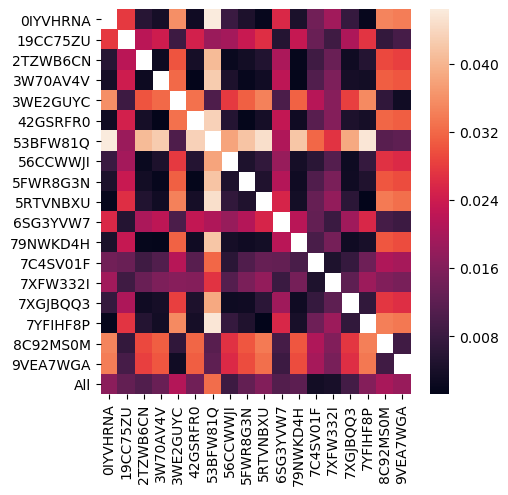

In [308]:
plt.figure(figsize=(5,5))
g = sns.heatmap(pd.DataFrame(dists).sort_index())
g.set_ylim(len(pd.DataFrame(dists)), 0)
plt.show()

I went on to see that if BBSE is estimated off of similar looking cells (based on the above distance calculation), can we get better estimates?

In [310]:
def get_close_cells(train_puff_probs, test_puff_probs, cell_memberships, k=3):
    cell_list = np.unique(cell_memberships)
    dists = [wd(test_puff_probs,
                train_puff_probs[cell_memberships == c]) for c in cell_list]
    return cell_list[np.argsort(dists)][0:k]

def correct_on_close_cells(train_puff_labels, train_puff_probs, test_puff_probs, cell_memberships, k=3):
    close_cells = get_close_cells(train_puff_probs, test_puff_probs, cell_memberships, k=k)
    close_train_probs = train_puff_probs[np.isin(cell_memberships, close_cells)]
    close_train_labels = train_puff_labels[np.isin(cell_memberships, close_cells)]
    return base_rate_correction(close_train_labels, close_train_probs, test_puff_probs)

In [298]:
for held_cell, classifier in rr_classifiers.items():
    test_puff_probs = labeled_sample.loc[labeled_sample['cell']==held_cell, 'proba'].values
    train_puff_probs = classifier.oob_decision_function_[:,1]
    train_puff_labels = labeled_sample.loc[labeled_sample['cell']!=held_cell, 'puff'].values
    cell_memberships = labeled_sample.loc[labeled_sample['cell']!=held_cell, 'cell'].values
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_mean'] = np.mean(test_puff_probs)
    cell_res.loc[cell_res['cell'] == held_cell ,'est_frac_raw_thresh'] = np.mean(test_puff_probs > 0.5)
    cell_res.loc[cell_res['cell'] == held_cell, 'est_frac_corr'] = base_rate_correction(train_puff_labels,
                                                                                        train_puff_probs,
                                                                                        test_puff_probs, thresh=0.5)
    cell_res.loc[cell_res['cell'] == held_cell, 'est_frac_corr_matched'] = correct_on_close_cells(train_puff_labels,
                                                                                                  train_puff_probs,
                                                                                                  test_puff_probs,
                                                                                                  cell_memberships,
                                                                                                  k=2)

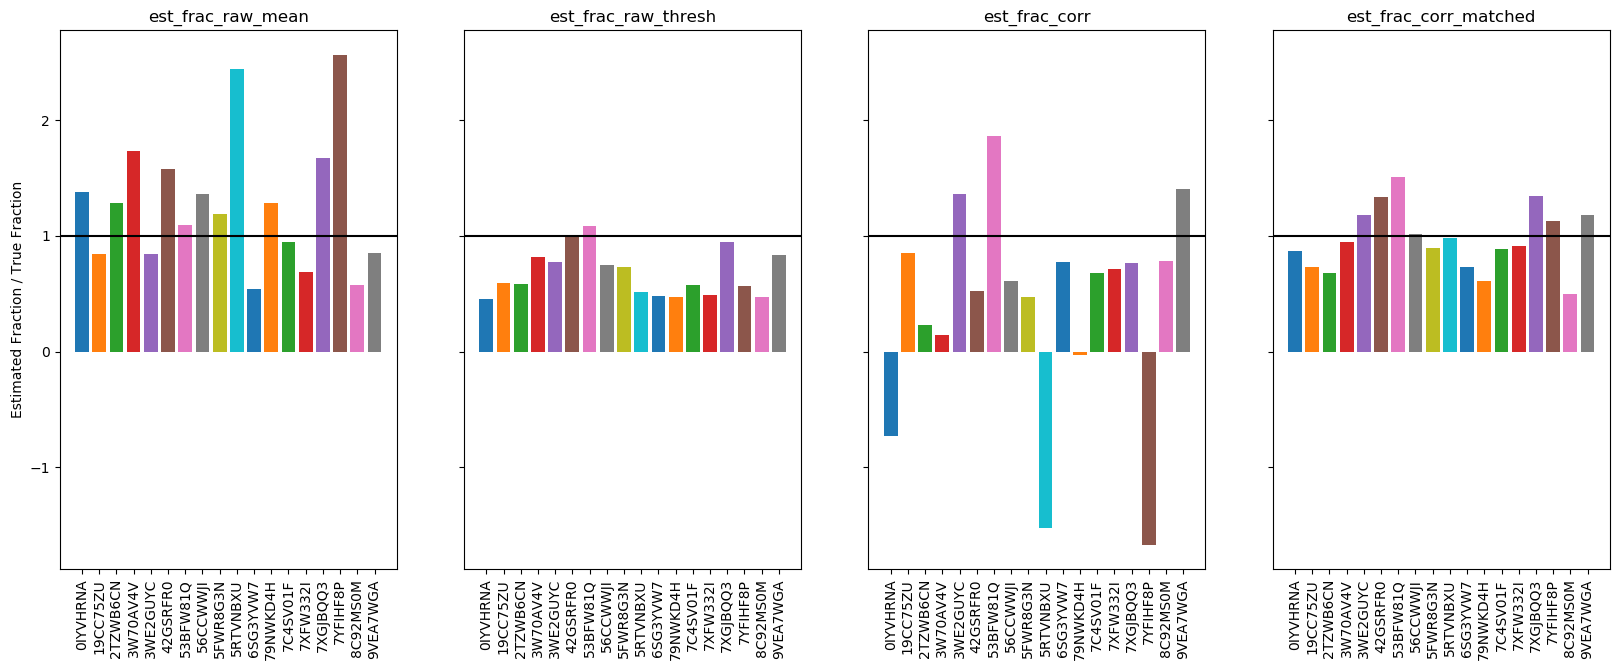

In [299]:
fig, axs = plt.subplots(1, 4, sharey = True, figsize=(20,7))
axs[0].set_ylabel('Estimated Fraction / True Fraction')

pred_diff = {}
for ax, est in enumerate(['est_frac_raw_mean', 'est_frac_raw_thresh', 'est_frac_corr', 'est_frac_corr_matched']):
    pred_diff[est] = cell_res[est] / cell_res['true_frac']
    for counter, cell in enumerate(cell_res['cell']):
        axs[ax].bar(cell, pred_diff[est][counter])
    axs[ax].set_xticklabels(cell_res['cell'], rotation='vertical')
    axs[ax].axhline(y=1, color = 'black')
    axs[ax].set_title(est)